In [44]:
# %pip install tensorflow
# %pip install pandas 
# %pip install numpy
# %pip install matplotlib
# %pip install scikit-learn


In [45]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

In [46]:
# Load the prepared datasets
features = pd.read_csv('prepared_data/prepared_features.csv', index_col=0, parse_dates=True)
targets = pd.read_csv('prepared_data/prepared_targets.csv', index_col=0, parse_dates=True)

# Handle NaN values
lag_columns = [col for col in features.columns if 'lag' in col or 'rolling' in col]
features_filled = features.copy()
features_filled[lag_columns] = features_filled[lag_columns].fillna(method='ffill')

# Then, drop any remaining rows with NaN values
features_cleaned = features_filled.dropna()
targets_cleaned = targets.loc[features_cleaned.index]

# Convert all data to float32
features_cleaned = features_cleaned.astype('float32')
targets_cleaned = targets_cleaned.astype('float32')

print("Cleaned features shape:", features_cleaned.shape)
print("Cleaned targets shape:", targets_cleaned.shape)

Cleaned features shape: (624, 43)
Cleaned targets shape: (624, 7)


/var/folders/62/r__yd2rs2jz73f2qx2dnmwx00000gn/T/ipykernel_44612/501474533.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_filled[lag_columns] = features_filled[lag_columns].fillna(method='ffill')


In [47]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_cleaned, targets_cleaned, test_size=0.2, shuffle=False
)

# Reshape input data for LSTM (samples, time steps, features)
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("Reshaped training set:", X_train_reshaped.shape)
print("Reshaped testing set:", X_test_reshaped.shape)

Reshaped training set: (499, 1, 43)
Reshaped testing set: (125, 1, 43)


In [48]:
model = Sequential([
    Bidirectional(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(1, X_train.shape[1])),
    Dropout(0.3),
    Bidirectional(LSTM(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01))),
    Dropout(0.3),
    Bidirectional(LSTM(32, activation='relu', return_sequences=False, kernel_regularizer=l2(0.01))),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(7)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

/Users/andersrodem/Documents/Progging/anvendt-data-science/myenv/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 1, 256)         │       176,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 1, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,423 (1.47 MB)

 Trainable params: 384,423 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Train the model
history = model.fit(
    X_train_reshaped, y_train.values,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 824.5422 - mae: 28.1901 - val_loss: 814.1356 - val_mae: 28.2699
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 818.9385 - mae: 28.1021 - val_loss: 810.4316 - val_mae: 28.2266
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 822.0613 - mae: 28.1635 - val_loss: 804.6262 - val_mae: 28.1413
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 802.3907 - mae: 27.8435 - val_loss: 790.8772 - val_mae: 27.9076
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 793.3908 - mae: 27.6903 - val_loss: 741.1731 - val_mae: 26.9910
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 713.5436 - mae: 26.1936 - val_loss: 512.2117 - val_mae: 21.7139
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 450.0251 - mae: 18.4610 - val_loss: 306.2907 - val_mae: 12.3598
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 361.3071 - mae: 14.8694 - val_loss: 285.7158 - val_mae: 14.2724
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━

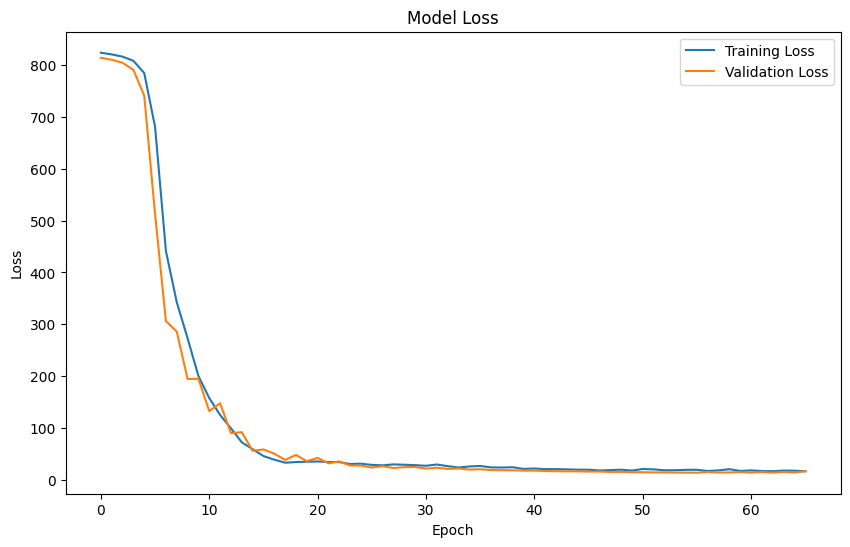

In [50]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x31f25a160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


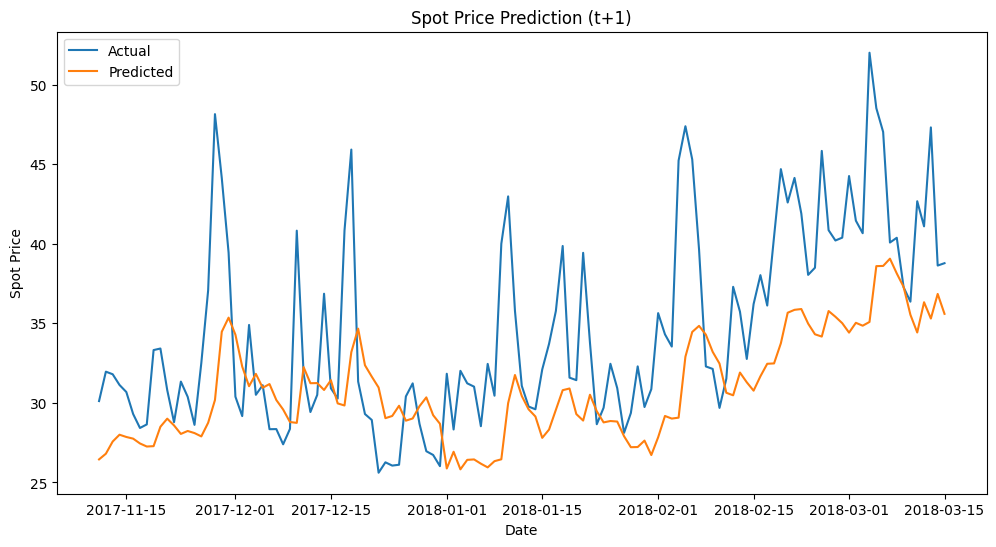

In [51]:
# Make predictions
predictions = model.predict(X_test_reshaped)

# Plot predictions vs actual for the first target (t+1)
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.iloc[:, 0], label='Actual')
plt.plot(y_test.index, predictions[:, 0], label='Predicted')
plt.title('Spot Price Prediction (t+1)')
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.legend()
plt.show()

MAE for t+1: 4.6693
MAE for t+2: 5.3218
MAE for t+3: 5.4288
MAE for t+4: 5.4425
MAE for t+5: 5.0419
MAE for t+6: 5.5437
MAE for t+7: 5.1283


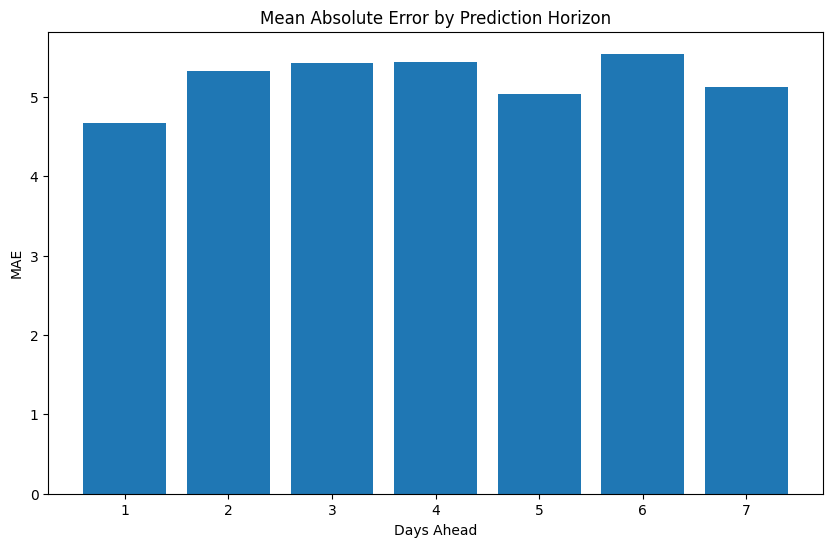

In [52]:
# Calculate Mean Absolute Error (MAE) for each prediction horizon
mae_scores = []
for i in range(7):
    mae = np.mean(np.abs(y_test.iloc[:, i] - predictions[:, i]))
    mae_scores.append(mae)
    print(f"MAE for t+{i+1}: {mae:.4f}")

# Plot MAE scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, 8), mae_scores)
plt.title('Mean Absolute Error by Prediction Horizon')
plt.xlabel('Days Ahead')
plt.ylabel('MAE')
plt.show()